### Example of PINN with 1D oscillatior.
This is an example of PINN and its application to simple physical use case. <br>
In a nutshell, PINN takes equations in the loss as physical constraint to the training of neural network, which increases the physical awareness of the neural network.

Here is a nice blog post about this topic: <br>
https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/

This notebook is inspired by the following work:
https://github.com/benmoseley/harmonic-oscillator-pinn

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

torch.manual_seed(1)

#### Definition of a 1D underdamped harmonic oscillator
Here we write down the mathematical expression of the oscillator and obtain the analytical solution of it.


In [2]:
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem."""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

Just for comparison, we define a simple multi layer percepton network to learn the oscillator.

In [3]:
class MLP(nn.Module):
    """Define a Multi Layer Percepton network to learn oscillator."""

    def __init__(self, input, output, hidden, layers):
        super().__init__()
        activation = nn.ReLU
        self.input = nn.Sequential(*[nn.Linear(input, hidden), activation()])
        hidden_layer = []
        for _ in range(layers):
            hidden_layer.extend([nn.Linear(hidden, hidden), activation()])
        self.mid = nn.Sequential(*hidden_layer) 
        self.output = nn.Linear(hidden, output)

    def forward(self, x):
        x = self.input(x)
        x = self.mid(x)
        x = self.output(x)

        return x

Now we generate both the training and testing data using the oscillator function.

In [4]:
# define constant of system
d = 2
w0 = 20

# get analytical solutions over time
x = torch.linspace(0, 1, 500).view(-1, 1)
y = oscillator(d, w0, x).view(-1, 1)
print(x.shape, y.shape)

torch.Size([500, 1]) torch.Size([500, 1])


torch.Size([10, 1]) torch.Size([10, 1])


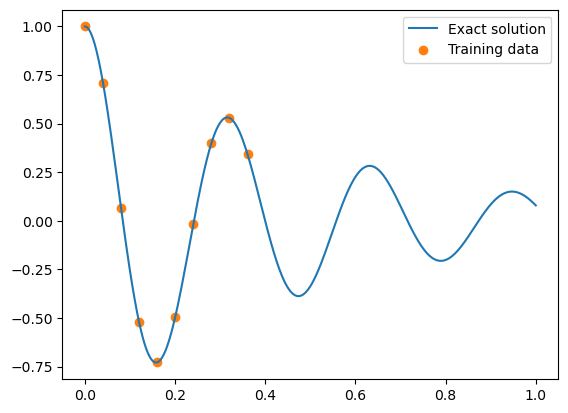

In [5]:
# check the training data
x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

In [6]:
# train network
model = MLP(1, 1, 32, 3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
# Specify loss function
criterion = nn.MSELoss()

for i in range(1000):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = criterion(yh, y_data)
    #loss = torch.mean((yh-y_data)**2)# use mean squared error
    loss.backward()
    optimizer.step()

In [7]:
def fancy_plot(x,y,x_data,y_data,yh,xp=None):
    """Fancy plot for training results."""
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")


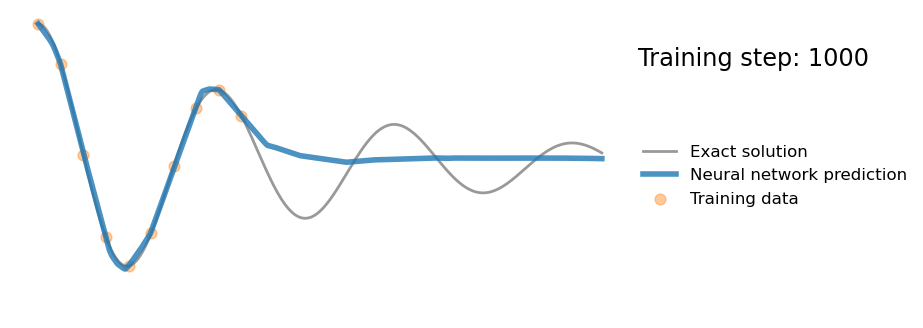

In [8]:
# plot training results
yh = model(x).detach()
fancy_plot(x,y,x_data,y_data,yh)

### PINN
Now we will implement PINN by adding differential equations to the loss function, to unlock the potential of the so-called physics-informed network.